Analysis of data from:

De Neuter, N., Bartholomeus, E., Elias, G., Keersmaekers, N., Suls, A., Jansens, H., … Ogunjimi, B. (2018). Memory CD4 + T cell receptor repertoire data mining as a tool for identifying cytomegalovirus serostatus. Genes & Immunity, 1. <https://doi.org/10.1038/s41435-018-0035-y>

Here's their description of the data:

> In this study, we collected peripheral blood samples from 9
CMV seropositive and 24 CMV seronegative healthy Belgian
adults. We sequenced TCRβ sequences from the CD4
+CD45RO+ lymphocyte population only, as opposed to the
CD4+CD45RO+/− and CD8+CD45RO+/- lymphocyte
populations collected in the original study [15], and thus
focused solely on the immune signal within the CD4+
memory repertoire. After removal of out of frame TCR
sequences, 2,204,828 distinct TCRβ sequences were
obtained, with a mean of 66 813 sequences per individual.

I took these 33 repertoires and randomly split them into 22 training sets and then 11 testing sets. 
The training sets were mixed and 10% used for actual training, with 90% available for validation.

(Note that the original data set has a few replicate samples from some of the repertoires, but I only selected one of the two replicates).

### Hey you, edit this path 👇 to point to your clone of the vampire repository

In [1]:
vampire_path = '/home/ematsen/re/vampire/'

In [2]:
suppressMessages(library(cowplot))
library(jsonlite)
library(latex2exp)
library(tools)
library(devtools)
suppressMessages(devtools::load_all(paste0(vampire_path, 'vampire/R/sumrep')))
theme_set(theme_minimal())
source_colors = c(basic = "#fc8d62", count_match = "#66c2a5", OLGA.Q ="#8da0cb", data = "#A3A3A3", train = "#444444")

In [3]:
json_path = 'input/_output_deneuter-2019-02-07/deneuter-2019-02-07.json'

data_dir = paste0(dirname(json_path),'/')
data_path = function(path) paste0(data_dir, path)
train_dir = str_replace(json_path, '.json', '.train/')

output_dir = 'output/'

In [4]:
data_json = fromJSON(json_path)
test_samples = lapply(
    data_json$test_paths,
    function(path) tools::file_path_sans_ext(basename(path)))

system(paste('mkdir -p ', output_dir))
output_path = function(path) paste0(output_dir, path)
# This notebook makes nice versions of plots in this directory:
normalizePath(output_dir)

[1] "/home/ematsen/re/vampire-analysis-1/output"

The following command should run if the data is in the right place.

In [5]:
summarized = data_path('summarized.agg.csv')
system(paste('ls', summarized), intern=TRUE)

[1] "input/_output_deneuter-2019-02-07/summarized.agg.csv"

---

We will be comparing the VAE methods to OLGA + the thymic Q multiplier suggested by Thierry. 
For simplicity we will be referring to this method as "OLGA.Q". 

---

Here we set the regularization parameter beta.

In [6]:
our_beta = 0.75
fit_dir = paste0(train_dir, our_beta, '/')
fit_path = function(path) paste0(fit_dir, path)

---

Let's compare the CDR3 length distribution between the various programs and the data sets. 
The programs will appear with thick colored lines, while the thin gray lines represent the test data sets.

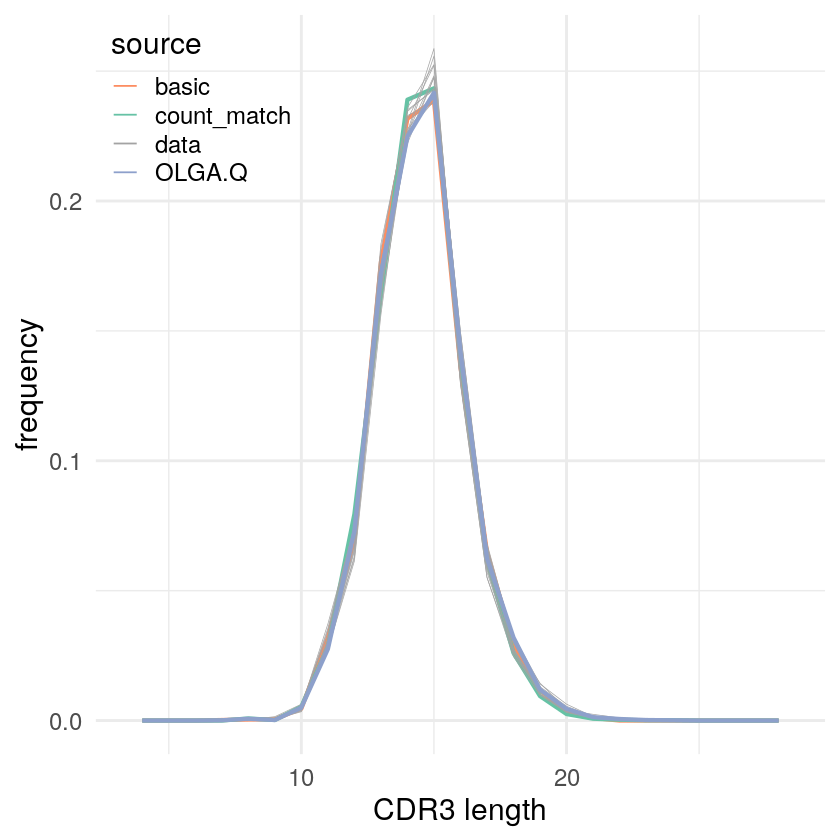

In [7]:
prep_sumrep = function(path) {
    df = read.csv(path, stringsAsFactors=FALSE)
    colnames(df)[colnames(df) == 'amino_acid'] = 'junction_aa'
    data.table(df)
}
named_summary = function(summary_fun, summary_name, path, data_source, data_group) {
    df = data.frame(summary_fun(path))
    colnames(df) = c(summary_name)
    df$source = data_source
    df$group = data_group
    df
}
prep_summaries_general = function(data_paths, olga_str, basic_str, count_match_str, summary_fun, summary_name) {
    aux = function(path, data_source, data_group) {
        named_summary(summary_fun, summary_name, path, data_source, data_group)
    }
    data_df = do.call(rbind, 
                 lapply(
                     data_paths,
                     function(path) aux(path, 'data', path)
                 ))
    df = rbind(
        aux(fit_path(olga_str), 'olga', 'olga'),
        aux(fit_path(basic_str), 'basic', 'basic'),
        aux(fit_path(count_match_str), 'count_match', 'count_match') 
    )
    df = rbind(df, data_df)
    df$size = 1-as.numeric(df$source == 'data')
    df
}
prep_summaries = function(summary_fun, summary_name) {
    test_head_csvs = 
        lapply(test_samples, function(sample) data_path(paste0(sample, '/', sample, '.head.csv')))
    prep_summaries_general(test_head_csvs, 'olga-generated.csv', 'basic/vae-generated.csv', 
                           'count_match/vae-generated.csv', summary_fun, summary_name)
}
plot_summaries = function(df, summary_name, binwidth=1) {
    theme_set(theme_minimal(base_size=18))
    df[df$source == 'olga', 'source'] = 'OLGA.Q'
    p = ggplot(df,
        aes_string(summary_name, color='source', group='group', size='size')) + 
        geom_freqpoly(aes(y=..density..), binwidth=binwidth) + 
        scale_size(range=c(0.2, 1.2), guide='none') +
        theme(legend.justification=c(0,1), legend.position=c(0,1)) +
        scale_color_manual(values=source_colors) + 
        xlab(gsub('_', ' ', summary_name)) +
        ylab('frequency')

    ggsave(output_path(paste0(summary_name, '.svg')), width=8, height=4.5)
    p
}

plot_summaries(prep_summaries(
    function(path) getCDR3LengthDistribution(prep_sumrep(path), by_amino_acid = TRUE), 
    'CDR3_length'), 'CDR3_length')

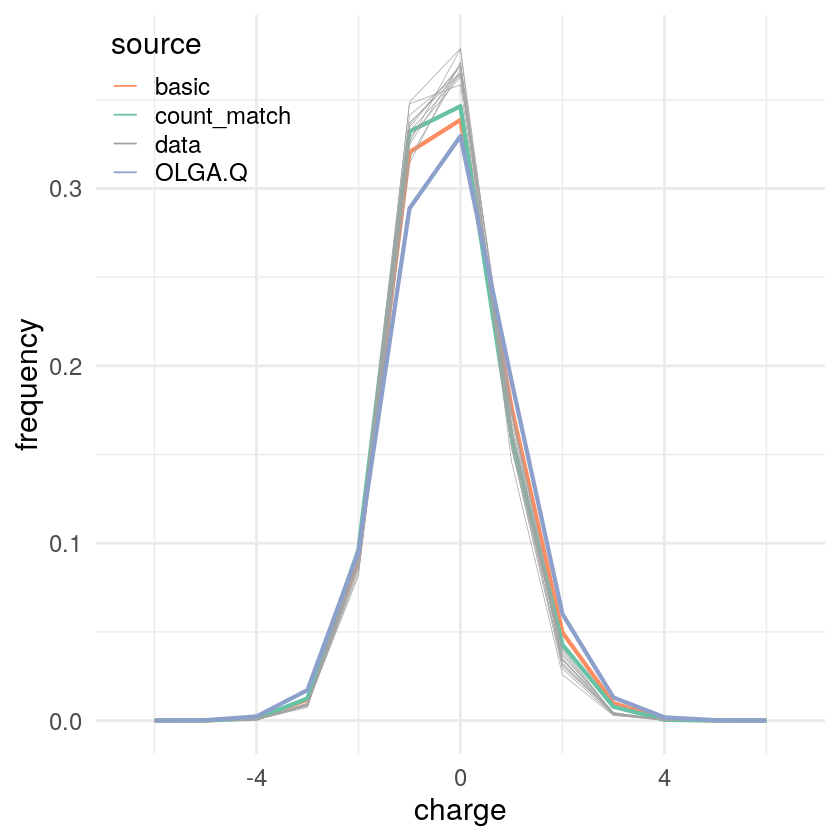

In [8]:
plot_summaries(prep_summaries(
    function(path) getChargeDistribution(prep_sumrep(path), column='junction_aa'),
    'charge'), 
'charge')

For each CDR3 sequence, let's look at the distance to the nearest neighbor CDR3 sequence.

In [ ]:
plot_summaries(prep_summaries(
    function(path) getNearestNeighborDistribution(prep_sumrep(path), column='junction_aa', tol=1e-6),
    'nearest_neighbor_Levenshtein_distance'), 
'nearest_neighbor_Levenshtein_distance')

Now let's explore the distribution of pairwise distances between the CDR3 sequences.

Let's look at divergences from the test sets for TCR sequences generated by the various programs.
Each data point in these plots is a divergence between the simulated set of sequences and a collection of sequences from the test set.

In [ ]:
df = read.csv(summarized, stringsAsFactors=FALSE)

facet_labeller = function(s) {
    s = sub("sumdiv_","",s)
    s = gsub("_"," ",s)
    s = sub("distance","dist",s)
    s
}

compare_model_divergences = function(df, beta) {
    df$synthetic = TRUE
    df[df$model == 'train', ]$synthetic = FALSE
    df = df[df$beta == beta,]
    df[df$model == 'olga', 'model'] = 'OLGA.Q'
    id_vars = c('test_set', 'model', 'synthetic')
    measure_vars = grep('sumdiv_', colnames(df), value=TRUE)
    df = df[c(id_vars, measure_vars)]
    theme_set(theme_minimal())
    ggplot(
        melt(df, id_vars, measure_vars, variable.name='divergence_name', value.name='divergence'),
        aes_string('model', 'divergence', color='model', shape='synthetic')
    ) + geom_point(position = position_jitterdodge(dodge.width=0.5, jitter.width=0.5)) +
        facet_wrap(vars(divergence_name), nrow=3, scales='free', labeller=as_labeller(facet_labeller)) +
        scale_y_log10() +
        scale_shape_manual(values=c(3, 16)) +
        theme(axis.text.x=element_blank(), axis.title.x = element_blank()) +
        scale_color_manual(values=source_colors) + 
        labs(color='data source')
}

compare_model_divergences(df, our_beta)
ggsave(output_path('sumrep_divergences.svg'), width=8, height=4.5)

---

Now let's look at a more sophisticated way of evaluating sequences, namely Ppost. 
If a synthetically generated sequence doesn't look like a real VDJ recombination, then Ppost will be low.

In [ ]:
get_ppost = function(path) read.csv(path)$Ppost

test_ppost_csvs = 
    lapply(test_samples, 
           function(sample) paste0(train_dir, sample, '.head/ppost.csv'))

summaries = prep_summaries_general(
    test_ppost_csvs, 'olga-generated.ppost.csv', 'basic/vae-generated.ppost.csv', 
    'count_match/vae-generated.ppost.csv', get_ppost, 'Ppost')
summaries$log_Ppost = log(summaries$Ppost)

plot_summaries(summaries, 'log_Ppost') + coord_cartesian(xlim=c(-50, -10)) + xlab(TeX("$\\log(P_{OLGA.Q})$"))
ggsave(output_path('log_Ppost.svg'), width=8, height=4.5)

What does Pvae look like?

In [ ]:
get_pvae = function(path) read.csv(path)$log_p_x

test_pvae_csvs = 
    lapply(test_samples, 
           function(sample) fit_path(paste0('basic/',sample,'.head/test.pvae.csv')))

summaries = prep_summaries_general(
    test_pvae_csvs, 'basic/olga-generated.pvae.csv', 'basic/vae-generated.pvae.csv', 
    'count_match/vae-generated.pvae.csv', get_pvae, 'log_Pvae')

plot_summaries(summaries, 'log_Pvae') + coord_cartesian(xlim=c(-50, -10)) + xlab(TeX("$\\log(P_{VAE})$"))
ggsave(output_path('log_Pvae.svg'), width=8, height=4.5)

Here we see the surprising result that Pvae is very similar between the VAE-generated sequences and the real sequences. That means that the VAE is not just memorizing the input sequences.

Also, we see that the VAE can tell the difference between OLGA-generated sequences and real sequences.

---

#### Latent space visualization

In [ ]:
# This file is made by running the bottom cells of the python.ipynb notebook.

df = read.csv('output/pcs.csv')

In [ ]:
v_genes = sort(unique(df$v_gene))
popular = data.frame(sort(table(df$v_gene), decreasing=TRUE))[1:7, 1]
v_plot = ggplot(df[df$v_gene %in% popular,], aes(pc_1, pc_2, color=v_gene)) + 
    geom_point(alpha=0.4) +
    coord_fixed() + 
    scale_color_discrete(name="V gene") + 
    xlab("") + ylab("PC 2")

j_plot = ggplot(df, aes(pc_1, pc_2, color=j_gene)) + 
    geom_point(alpha=0.4) +
    scale_color_discrete(name="J gene") + 
    coord_fixed() + 
    xlab("PC 1") + ylab("PC 2")

p = plot_grid(v_plot, j_plot, labels = c("(a)", "(b)"), ncol=1)
ggsave('output/gene_pca.png', plot=p, width=8, height=8)

In [ ]:
df = read.csv('output/pcs_topgenes.csv')
p = ggplot(df, aes(pc_1, pc_2)) + ggtitle('TCRBV30-01 / TCRBJ01-02')
data.frame(number = seq_along(colnames(df)), name = colnames(df))

In [ ]:
p + geom_point(aes_string(color = 'test_set'))

In [ ]:
p + geom_point(aes_string(color = 'cdr3_length')) + scale_colour_viridis_c(option = "plasma")

In [ ]:
lapply(colnames(df)[seq(5,20)], function(s) p + geom_point(aes_string(color = s)))